In [1]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [2]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/validation'

In [3]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for lbl in os.listdir(directory):
        label_dir = os.path.join(directory, lbl)
        if not os.path.isdir(label_dir):
            continue
        for imagename in os.listdir(label_dir):
            image_paths.append(os.path.join(label_dir, imagename))
            labels.append(lbl)
        print(lbl, "complete")
    return image_paths, labels

In [4]:
images, labs = create_dataframe(TRAIN_DIR)
train = pd.DataFrame({'image': images, 'label': labs})

angry complete
disgust complete
fear complete
happy complete
neutral complete
sad complete
surprise complete


In [5]:
print (train)

                                image     label
0            images/train\angry\0.jpg     angry
1            images/train\angry\1.jpg     angry
2           images/train\angry\10.jpg     angry
3        images/train\angry\10002.jpg     angry
4        images/train\angry\10016.jpg     angry
...                               ...       ...
28816  images/train\surprise\9969.jpg  surprise
28817  images/train\surprise\9985.jpg  surprise
28818  images/train\surprise\9990.jpg  surprise
28819  images/train\surprise\9992.jpg  surprise
28820  images/train\surprise\9996.jpg  surprise

[28821 rows x 2 columns]


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = create_dataframe(TEST_DIR)

angry complete
disgust complete
fear complete
happy complete
neutral complete
sad complete
surprise complete


In [7]:
print (test)
print (test['image'])

                                    image     label
0       images/validation\angry\10052.jpg     angry
1       images/validation\angry\10065.jpg     angry
2       images/validation\angry\10079.jpg     angry
3       images/validation\angry\10095.jpg     angry
4       images/validation\angry\10121.jpg     angry
...                                   ...       ...
7061  images/validation\surprise\9806.jpg  surprise
7062  images/validation\surprise\9830.jpg  surprise
7063  images/validation\surprise\9853.jpg  surprise
7064  images/validation\surprise\9878.jpg  surprise
7065   images/validation\surprise\993.jpg  surprise

[7066 rows x 2 columns]
0         images/validation\angry\10052.jpg
1         images/validation\angry\10065.jpg
2         images/validation\angry\10079.jpg
3         images/validation\angry\10095.jpg
4         images/validation\angry\10121.jpg
                       ...                 
7061    images/validation\surprise\9806.jpg
7062    images/validation\surprise\9830.jpg

In [8]:
from tqdm import tqdm

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # load_img: use color_mode='grayscale' and resize to 48x48
        img = load_img(image, color_mode='grayscale', target_size=(48,48))
        arr = np.array(img, dtype=np.float32)
        # ensure channel dimension exists (H, W, 1)
        if arr.ndim == 2:
            arr = arr[..., np.newaxis]
        features.append(arr)
    features = np.stack(features, axis=0)
    # normalize to [0,1]
    features /= 255.0
    return features

In [10]:
train_features = extract_features(train['image'])

100%|██████████| 28821/28821 [00:03<00:00, 8483.23it/s]


In [11]:
# generate validation features from the validation/test dataframe
validation_features = extract_features(test['image'])
# extract_features already normalizes to [0,1], so do not divide again
x_train = train_features
x_validation = validation_features

100%|██████████| 7066/7066 [00:00<00:00, 8346.29it/s]


In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [14]:
y_train = le.transform(train['label'])
y_validation = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_validation = to_categorical(y_validation, num_classes=7)

In [16]:
model = Sequential()  # convolutional layers
from keras.layers import Input
model.add(Input(shape=(48,48,1)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x = x_train, y = y_train, epochs=20, batch_size=32, validation_data=(x_validation, y_validation))

Epoch 1/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 201s 223ms/step - accuracy: 0.4222 - loss: 1.4941 - val_accuracy: 0.4614 - val_loss: 1.3824
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 241s 266ms/step - accuracy: 0.4338 - loss: 1.4670 - val_accuracy: 0.4841 - val_loss: 1.3453
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 172s 190ms/step - accuracy: 0.4452 - loss: 1.4436 - val_accuracy: 0.4953 - val_loss: 1.3338
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 99s 110ms/step - accuracy: 0.4473 - loss: 1.4268 - val_accuracy: 0.4973 - val_loss: 1.3179
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.4573 - loss: 1.4149 - val_accuracy: 0.4880 - val_loss: 1.3246
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 233s 259ms/step - accuracy: 0.4609 - loss: 1.4016 - val_accuracy: 0.5040 - val_loss: 1.2960
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 241s 268ms/step - accuracy: 0.4639 - loss: 1.3910 - val_accuracy: 0.5205 - val_loss: 1.2583
Epoch 8/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 241s 268ms/step - accuracy: 0.4720 - 

In [21]:
model_json = model.to_json()
with open("emotiondetector.json", 'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

In [22]:
from keras.models import model_from_json

In [23]:
json_file = open('emotiondetector.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights('emotiondetector.h5')

In [24]:
label = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'sad', 'Surprise']

In [25]:
def ef(images):
    features = []
    for image in images:
        img = load_img(image, color_mode='grayscale', target_size=(48,48))
        arr = np.array(img, dtype=np.float32)
        if arr.ndim == 2:
            arr = arr[..., np.newaxis]
        features.append(arr)
    features = np.stack(features, axis=0)
    features /= 255.0
    return features

In [26]:
# Predict a single image: pass the path as a list to ef()
image_path = 'images/train/sad/42.jpg'
print('original image is sad')
# ef expects an iterable of paths, so wrap in a list
X = ef([image_path])  # returns shape (1,48,48,1)
pred = model.predict(X)
# get predicted class index for the first (and only) sample
pred_idx = int(np.argmax(pred, axis=1)[0])
pred_label = label[pred_idx]
print("model predicted it as:", pred_label)

original image is sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
model predicted it as: sad


In [28]:
import matplotlib.pyplot as plt 
%matplotlib inline

original image is sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
model predicted it as: sad


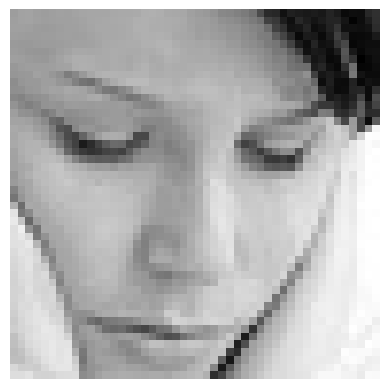

In [29]:
# Predict a single image: pass the path as a list to ef()
image_path = 'images/train/sad/42.jpg'
print('original image is sad')
# ef expects an iterable of paths, so wrap in a list
X = ef([image_path])  # returns shape (1,48,48,1)
pred = model.predict(X)
# get predicted class index for the first (and only) sample
pred_idx = int(np.argmax(pred, axis=1)[0])
pred_label = label[pred_idx]
print("model predicted it as:", pred_label)
# display the image (squeeze channel dimension)
img_arr = X[0].squeeze()
import matplotlib.pyplot as plt
plt.imshow(img_arr, cmap='gray')
plt.axis('off')
plt.show()